In [41]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math

In [42]:
df=pd.read_csv("speeddating.csv", sep=",")

df.columns

C:\Users\krist\AppData\Local\Temp\ipykernel_19560\3105991869.py:1: DtypeWarning: Columns (3,10,11,15,16,17,18,19,39,40,41,42,43,44,51,52,53,54,55,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,107,109) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("speeddating.csv", sep=",")


Index(['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age',
       'race', 'race_o', 'samerace',
       ...
       'd_expected_num_interested_in_me', 'd_expected_num_matches', 'like',
       'guess_prob_liked', 'd_like', 'd_guess_prob_liked', 'met', 'decision',
       'decision_o', 'match'],
      dtype='object', length=123)

EDA

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
has_null,8378.0,0.874910,0.330840,0.0,1.0,1.0,1.0,1.0
wave,8378.0,11.350919,5.995903,1.0,7.0,11.0,15.0,21.0
d_age,8378.0,4.185605,4.596171,0.0,1.0,3.0,5.0,37.0
samerace,8378.0,0.395799,0.489051,0.0,0.0,0.0,1.0,1.0
decision,8378.0,0.419909,0.493573,0.0,0.0,0.0,1.0,1.0
decision_o,8378.0,0.419551,0.493515,0.0,0.0,0.0,1.0,1.0
match,8378.0,0.164717,0.370947,0.0,0.0,0.0,0.0,1.0


In [44]:
df.describe(exclude=np.number)

,gender,age,age_o,d_d_age,race,race_o,importance_same_race,importance_same_religion,d_importance_same_race,d_importance_same_religion,...,expected_num_interested_in_me,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met
count,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378,...,8378,8378,8378,8378,8378,8378,8378,8378,8378,8378
unique,2,31,25,4,6,6,18,16,3,3,...,19,18,3,3,3,19,20,3,3,8
top,male,27,27,[2-3],European/Caucasian-American,European/Caucasian-American,1,1,[2-5],[0-1],...,?,2,[5-6],[0-3],[0-2],7,5,[6-8],[5-6],0
freq,4194,1037,1059,2406,4727,4722,2754,2944,3104,3111,...,6578,1695,4036,7346,4514,1816,1799,4827,3199,7644


In [45]:
#Pozrel som sa ako vyzerajú dáta
df.age.unique()

array(['21', '24', '25', '23', '22', '26', '27', '30', '28', '?', '29',
       '34', '35', '32', '39', '20', '19', '18', '37', '33', '36', '31',
       '42', '38', '55', 23, 24, 30, 28, 27, 25], dtype=object)

In [46]:
#kukol som či tu sú duplikáty
print("Duplicates:")
duplicates = df.duplicated()
print(df[duplicates])


Duplicates:
Empty DataFrame
Columns: [has_null, wave, gender, age, age_o, d_age, d_d_age, race, race_o, samerace, importance_same_race, importance_same_religion, d_importance_same_race, d_importance_same_religion, field, pref_o_attractive, pref_o_sincere, pref_o_intelligence, pref_o_funny, pref_o_ambitious, pref_o_shared_interests, d_pref_o_attractive, d_pref_o_sincere, d_pref_o_intelligence, d_pref_o_funny, d_pref_o_ambitious, d_pref_o_shared_interests, attractive_o, sinsere_o, intelligence_o, funny_o, ambitous_o, shared_interests_o, d_attractive_o, d_sinsere_o, d_intelligence_o, d_funny_o, d_ambitous_o, d_shared_interests_o, attractive_important, sincere_important, intellicence_important, funny_important, ambtition_important, shared_interests_important, d_attractive_important, d_sincere_important, d_intellicence_important, d_funny_important, d_ambtition_important, d_shared_interests_important, attractive, sincere, intelligence, funny, ambition, d_attractive, d_sincere, d_intelligence

Okej, máme missing values v podobe '?' ale nie duplikáty

In [47]:
# Nahrada NaN/<NA> za ?, oprava rôznych data typov v stĺpci, následna oprava opravy naspäť na int z float(kvôli NaN)
df = df.replace("?", np.nan)


#Keďže dropnutie všetkých NaN spôsobí stratu 80% dát, treba imputovať kde sa dá

# match, gender, akékoľvek descison či age sa nedá/nemá zmysel imputovať
# predpokladám že veľmi podstatné pre match bude ako vidí človek druhého človeka, teda nebudem imputovať ani určité vlastnsti s '_o'
critical = [
    'match',
    'gender',
    'age',
    'age_o',
    'decision',
    'decision_o',
    'attractive_o',
    'sinsere_o',
    'intelligence_o',
    'funny_o',
    'ambitous_o',
    'shared_interests_o'
]
df_clean=df.dropna(subset=critical)
df_clean=df_clean.drop('expected_num_interested_in_me', axis=1)#80% missing hodnôt
df_clean=df_clean.drop('has_null', axis=1)#zbytočnosť
df_clean=df_clean.drop('wave', axis=1)#zbytočnosť

df_clean = df_clean.apply(pd.to_numeric, errors='ignore')
df.shape, df_clean.shape
# práve sme dropli asi 18% dát(hopefully ok)

C:\Users\krist\AppData\Local\Temp\ipykernel_19560\3892125334.py:28: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_clean = df_clean.apply(pd.to_numeric, errors='ignore')


((8378, 123), (6880, 120))

In [48]:
#vyhodenie intervalových dát
import re

cols_to_drop = []

pattern = re.compile(r'^\[\d+\s*-\s*\d+\]$')   # napr. [2-3] alebo [4 - 6]

for col in df.columns:
    # skontroluj len ne-null stringy v danom stĺpci
    col_values = df[col].dropna().astype(str)
    if any(col_values.str.match(pattern)):
        cols_to_drop.append(col)

df_clean = df_clean.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)
#All in all, nám zostalo 67 stĺpcov

Dropped columns: ['d_d_age', 'd_importance_same_race', 'd_importance_same_religion', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important', 'd_ambtition_important', 'd_shared_interests_important', 'd_attractive', 'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition', 'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner', 'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner', 'd_sports', 'd_tvsports', 'd_exercise', 'd_dining', 'd_museums', 'd_art', 'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv', 'd_theater', 'd_movies', 'd_concerts', 'd_music', 'd_shopping', 'd_yoga', 'd_expected_happy_with_sd_people', 'd_expected_num_interested_in_me', 'd_expected_num_matches', 

In [49]:
df_clean.select_dtypes(exclude='number').isna().sum()
#Since there is nothing gonna replace missing data with median

gender                   0
race                     0
race_o                   0
field                    0
d_interests_correlate    0
dtype: int64

Nejaké grafíky na rozhodovanie ohľadom outlierov/hlavných prediktorov

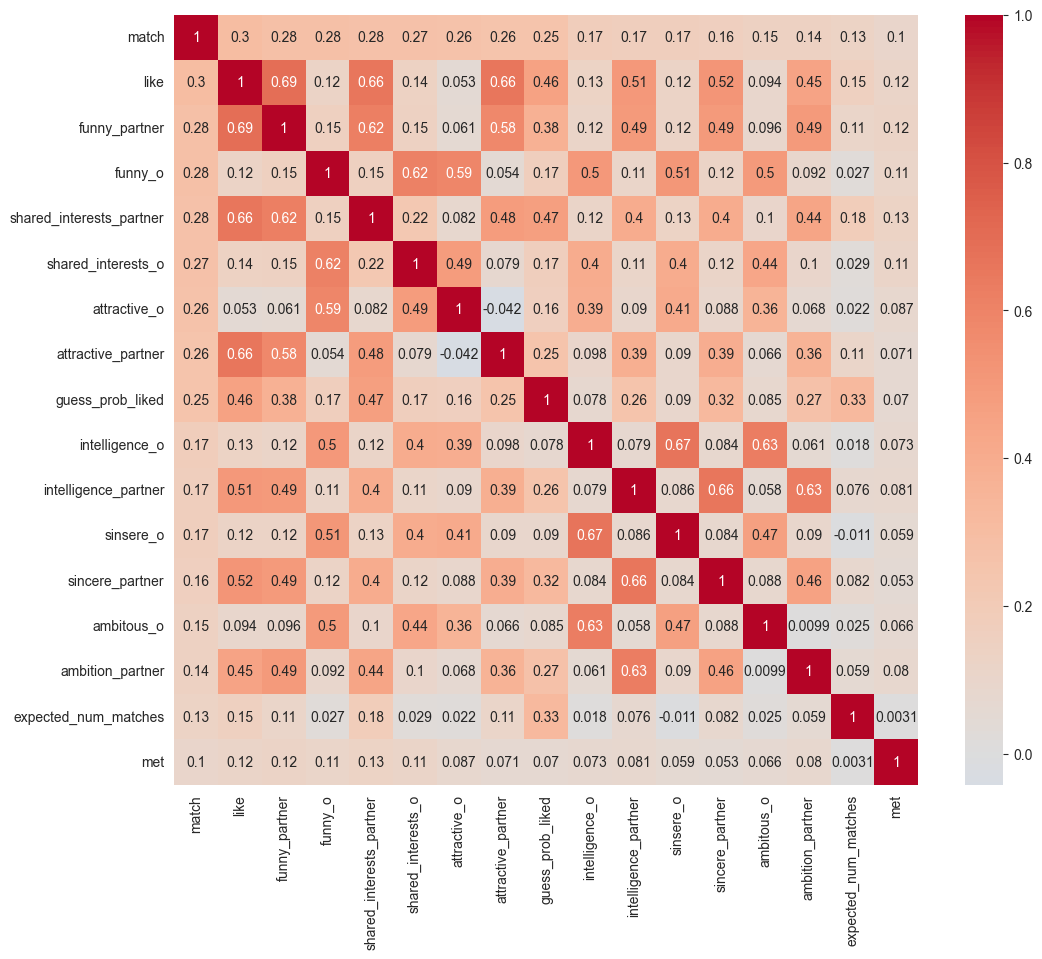

In [50]:
target_corr = df_clean.select_dtypes(include='number').corr()['match'].sort_values(ascending=False)
target_corr = target_corr.drop(["decision_o", "decision"], errors="ignore")
top_features = target_corr.abs().sort_values(ascending=False).head(17).index

plt.figure(figsize=(12,10))
sns.heatmap(df_clean[top_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.show()

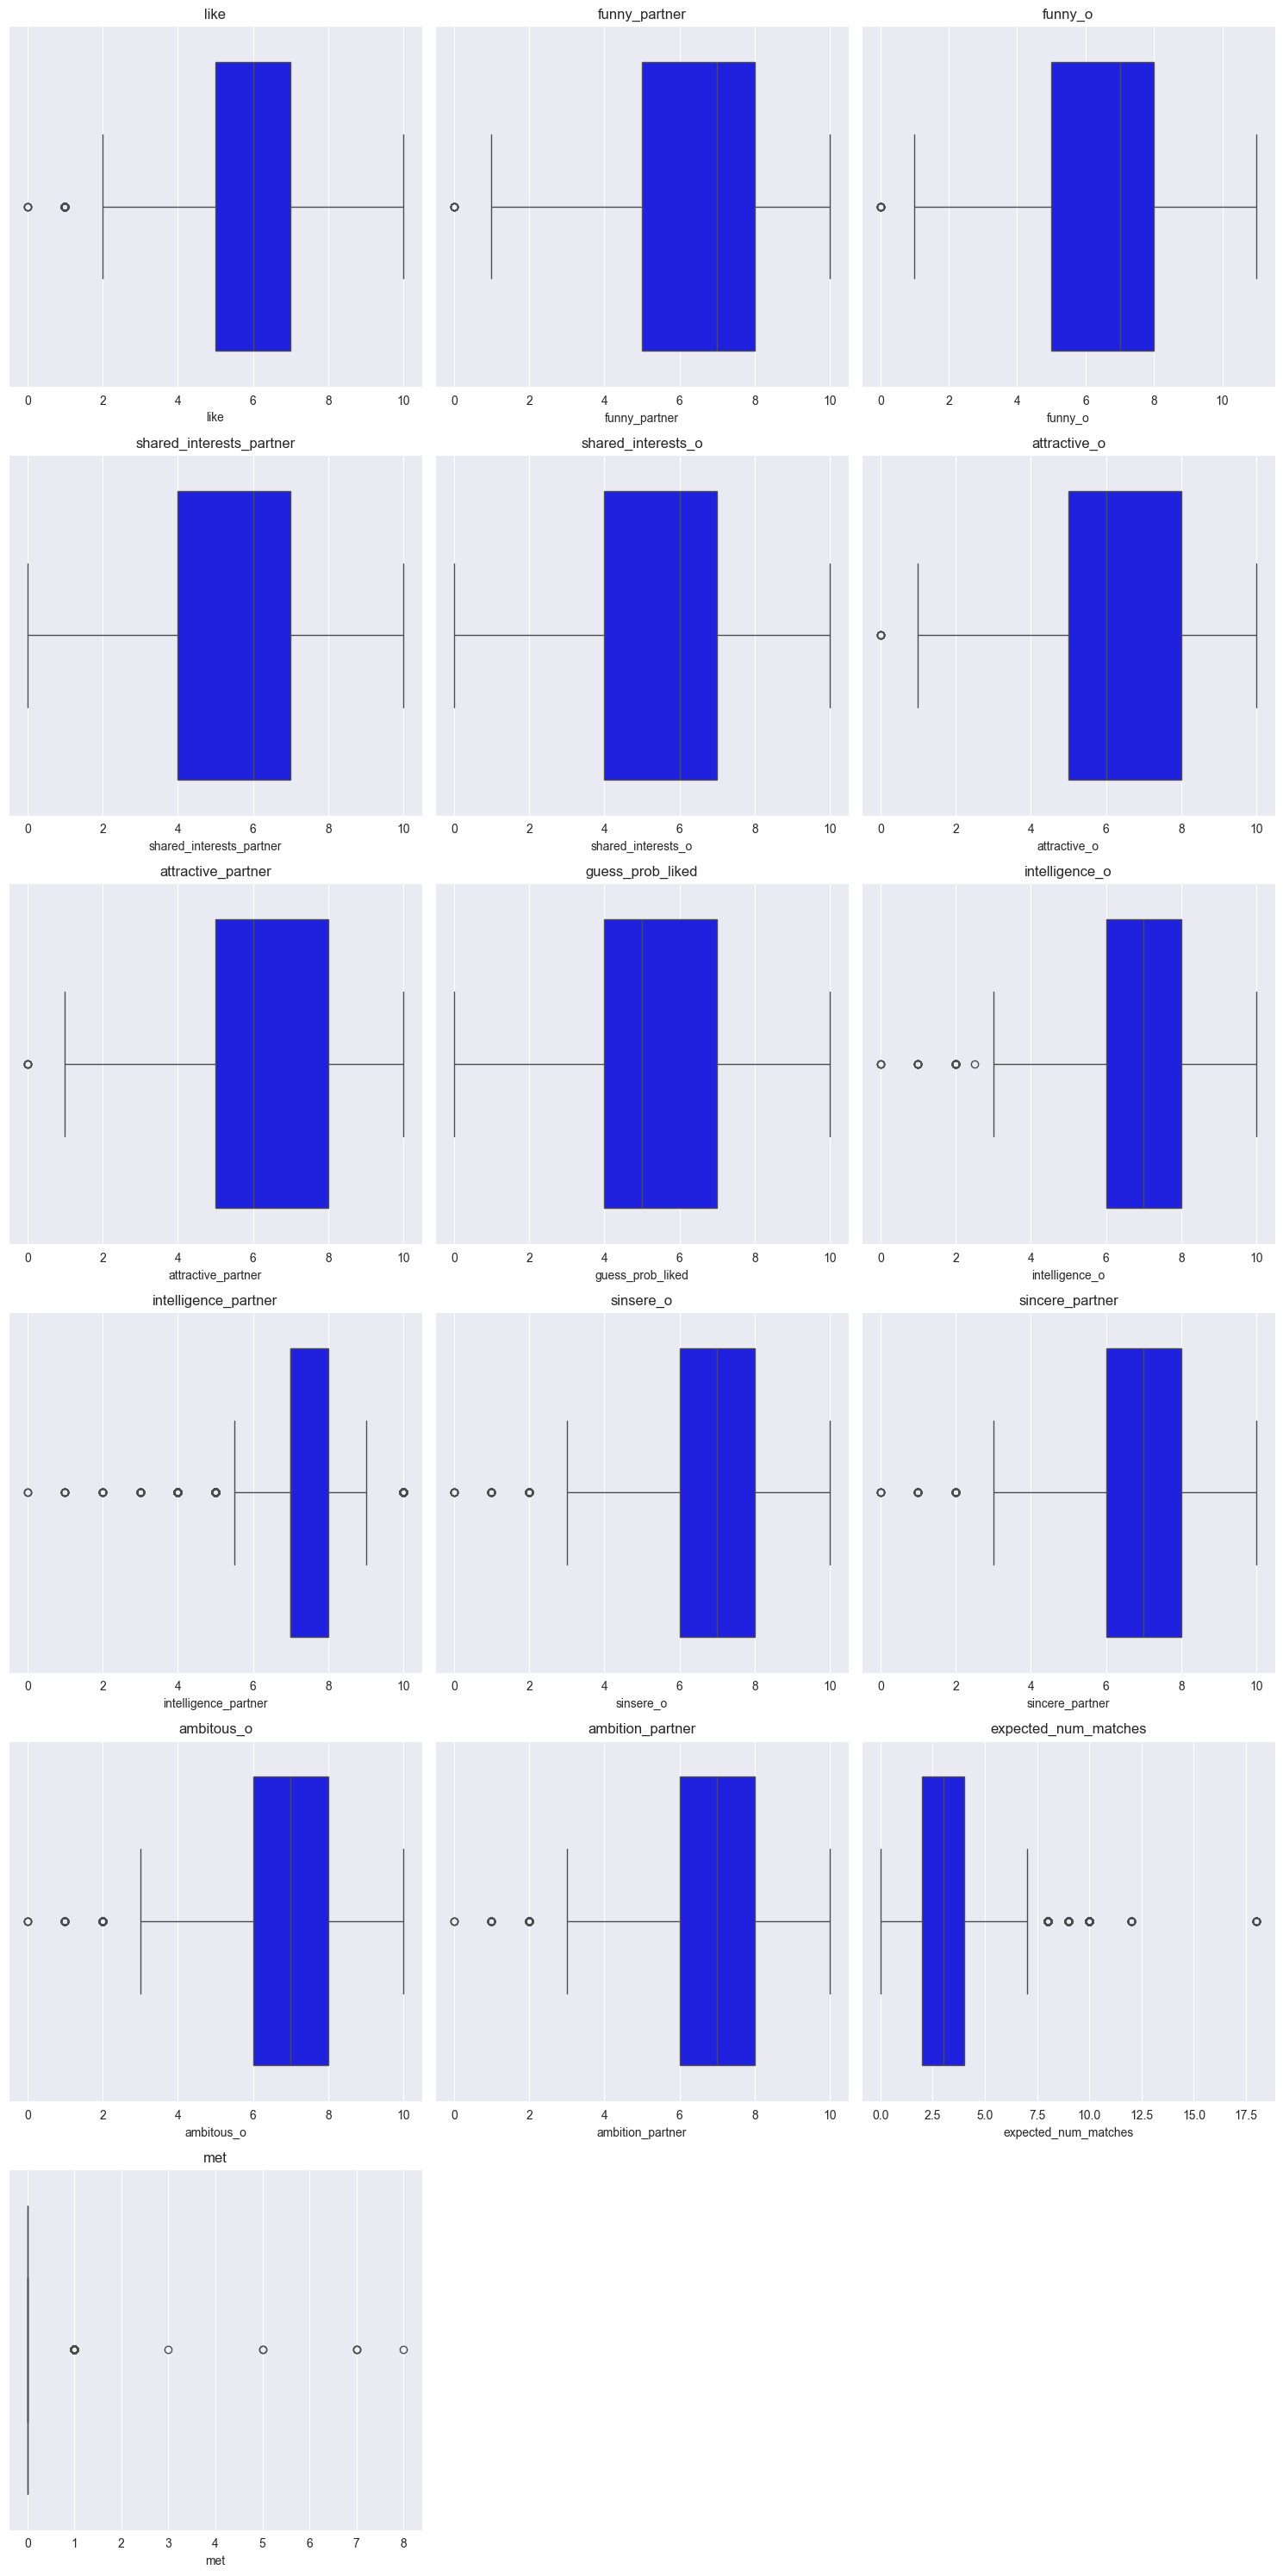

In [51]:
#Boxploty pre najviac korelujúce stĺpce, mimo tie čo majú binárnu hodnotu
cols = [c for c in top_features if df_clean[c].nunique() > 2]

n = len(cols)
rows = math.ceil(n / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
axes = axes.flatten()
for ax, col in zip(axes, cols):
    sns.boxplot(x=df_clean[col], ax=ax, color="blue")
    ax.set_title(col)
for ax in axes[n:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

Riešenie outlierov

In [52]:
def identify_outliers_z(df, hranica = 3):
    mean = df.mean()
    std = df.std()
    z_skore = (df-mean)/std
    return df[np.abs(z_skore) > hranica]

indexy_z = set()

print("Počet outlierov")
for col in df_clean.select_dtypes(include=[np.number]):
    outliers_z = identify_outliers_z(df_clean[col])
    if len(outliers_z)>0:
        print(f"{col}: {len(outliers_z)}")
        indexy_z.update(outliers_z.index)

Počet outlierov
age: 55
age_o: 44
d_age: 87
pref_o_attractive: 133
pref_o_sincere: 85
pref_o_intelligence: 123
pref_o_funny: 60
pref_o_ambitious: 21
attractive_o: 7
sinsere_o: 43
intelligence_o: 49
funny_o: 12
ambitous_o: 43
attractive_important: 138
sincere_important: 85
intellicence_important: 82
funny_important: 60
ambtition_important: 22
attractive: 18
sincere: 128
intelligence: 55
funny: 77
ambition: 82
attractive_partner: 6
sincere_partner: 39
intelligence_partner: 38
funny_partner: 8
ambition_partner: 36
dining: 62
museums: 13
gaming: 65
reading: 9
theater: 13
movies: 59
concerts: 13
music: 73
interests_correlate: 4
expected_num_matches: 48
like: 4
met: 325


### Riesenie vychylenych hodnot pomocou Z-score


Počet outlierov podľa z-skóre (|z| > 3):
d_age: 223


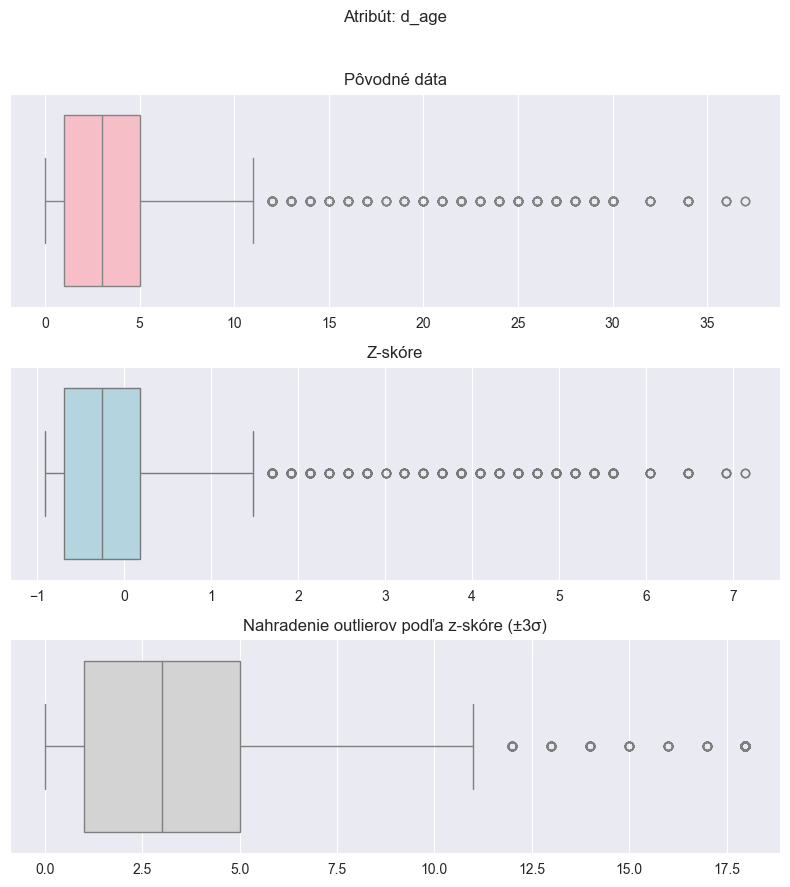

In [53]:
# to je pre z score
k = 3

#vybral som len tie ktoré majú aspoň 22 rôznych hodnôt(22 kvôli wave)
num_cols = df.select_dtypes(include='number').columns
columns_of_interest = [c for c in df_clean if df[c].nunique() > 22]

cols = [c for c in columns_of_interest if c in num_cols]
if not cols: 
    cols = list(num_cols)

means = df[cols].mean(skipna=True)#ignorujem nan hodnoty
stds  = df[cols].std(skipna=True) 
stds_safe = stds.replace(0, np.nan)#nechceme delit nulou tak radsej dame ako nan
z_df  = (df[cols] - means) / stds_safe
z_df  = z_df.replace([np.inf, -np.inf], np.nan)
lower = means - k * stds
upper = means + k * stds
df_wins = df.copy()
df_wins[cols] = df[cols].clip(lower=lower, upper=upper, axis=1)


print(f"\nPočet outlierov podľa z-skóre (|z| > {k}):")

pocet = (np.abs(z_df["d_age"]) > k).sum(skipna=True)
print(f"d_age: {pocet}")


fig, axes = plt.subplots(3, 1, figsize=(8, 9))
fig.suptitle("Atribút: d_age", y=0.98)
#povodne data
sns.boxplot(x=df["d_age"], ax=axes[0], color='lightpink')
axes[0].set_title("Pôvodné dáta")
axes[0].set_xlabel("")
 #z-score
sns.boxplot(x=z_df["d_age"], ax=axes[1], color='lightblue')
axes[1].set_title("Z-skóre")
axes[1].set_xlabel("")
#nahradim to podla z-score
sns.boxplot(x=df_wins["d_age"], ax=axes[2], color='lightgray')
axes[2].set_title(f"Nahradenie outlierov podľa z-skóre (±{k}σ)")
axes[2].set_xlabel("")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [54]:
print(columns_of_interest)

['age', 'age_o', 'd_age', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'interests_correlate']


### Nahradim missing values realnym cislo -> pouzijeme medianom

#### Pozrieme sa kolko sme mali missing_values

In [55]:
nan_counts = df[columns_of_interest].isna().sum()
nan_pct = (df[columns_of_interest].isna().mean() * 100).round(2)

summary_nan = pd.DataFrame({"NaN_count": nan_counts, "NaN_pct": nan_pct}).sort_values("NaN_count", ascending=False)
display(summary_nan) 

,NaN_count,NaN_pct
interests_correlate,158,1.89
pref_o_shared_interests,129,1.54
shared_interests_important,121,1.44
pref_o_ambitious,107,1.28
age_o,104,1.24
ambtition_important,99,1.18
pref_o_funny,98,1.17
age,95,1.13
pref_o_attractive,89,1.06
funny_important,89,1.06


#### Ideme nahradit NaN medianom

In [56]:
cols_present = [c for c in columns_of_interest if c in df_clean.columns]
if not cols_present:
    raise ValueError("V df_clean sa nenašiel žiadny stĺpec zo zoznamu columns_of_interest.")


df_clean_filled = df_clean.copy()

print("Pokus o konverziu stĺpcov na číselné (iba columns_of_interest):")
problem_samples = {}

for c in cols_present:
    s = df_clean_filled[c]


    if pd.api.types.is_numeric_dtype(s):
        continue


    s_str = s.astype(str).str.strip()
    s_str = s_str.replace({"": np.nan, "nan": np.nan, "None": np.nan})
    s_str = s_str.str.replace(",", ".", regex=False)

 
    s_num = pd.to_numeric(s_str, errors="coerce")


    mask_bad = s_str.notna() & s_num.isna()
    if mask_bad.any():
        problem_samples[c] = s_str[mask_bad].value_counts().head(5)

    df_clean_filled[c] = s_num

if problem_samples:
    print("\nNenačíselné hodnoty, ktoré sa nedali previesť (top 5):")
    for c, vc in problem_samples.items():
        print(f" - {c}:")
        for val, cnt in vc.items():
            print(f"     '{val}': {cnt}")


print("\nNahrádzam NaN hodnoty mediánom (iba columns_of_interest):")
skipped_all_nan = []
replaced_summary = []

for c in cols_present:
    if not pd.api.types.is_numeric_dtype(df_clean_filled[c]):
   
        continue

    before = df_clean_filled[c].isna().sum()
    med = df_clean_filled[c].median(skipna=True)

    if pd.isna(med): 
        skipped_all_nan.append(c)
        continue

    df_clean_filled[c] = df_clean_filled[c].fillna(med)
    after = df_clean_filled[c].isna().sum()
    replaced_summary.append((c, before - after, float(med)))

for c, replaced, med in replaced_summary:
    print(f"- {c}: nahradených {replaced} NaN (medián = {med})")

if skipped_all_nan:
    print("\nPreskočené stĺpce (všetky hodnoty NaN, medián sa nedal určiť):")
    print(", ".join(skipped_all_nan))


summary_nan_after = df_clean_filled[cols_present].isna().sum().to_frame("NaN_po_nahradeni")
display(summary_nan_after)

Pokus o konverziu stĺpcov na číselné (iba columns_of_interest):

Nenačíselné hodnoty, ktoré sa nedali previesť (top 5):
 - field:
     'Business': 404
     'Law': 394
     'MBA': 369
     ''Social Work'': 323
     ''International Affairs'': 212

Nahrádzam NaN hodnoty mediánom (iba columns_of_interest):
- age: nahradených 0 NaN (medián = 26.0)
- age_o: nahradených 0 NaN (medián = 26.0)
- d_age: nahradených 0 NaN (medián = 3.0)
- pref_o_attractive: nahradených 15 NaN (medián = 20.0)
- pref_o_sincere: nahradených 15 NaN (medián = 18.0)
- pref_o_intelligence: nahradených 15 NaN (medián = 20.0)
- pref_o_funny: nahradených 24 NaN (medián = 18.0)
- pref_o_ambitious: nahradených 24 NaN (medián = 10.0)
- pref_o_shared_interests: nahradených 46 NaN (medián = 10.26)
- attractive_important: nahradených 14 NaN (medián = 20.0)
- sincere_important: nahradených 14 NaN (medián = 18.37)
- intellicence_important: nahradených 14 NaN (medián = 20.0)
- funny_important: nahradených 22 NaN (medián = 18.0)
- a

C:\Users\krist\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,NaN_po_nahradeni
age,0
age_o,0
d_age,0
field,6880
pref_o_attractive,0
pref_o_sincere,0
pref_o_intelligence,0
pref_o_funny,0
pref_o_ambitious,0
pref_o_shared_interests,0


In [58]:
df_clean.isna().sum()

gender                0
age                   0
age_o                 0
d_age                 0
race                  0
                   ... 
guess_prob_liked    145
met                 196
decision              0
decision_o            0
match                 0
Length: 66, dtype: int64

Vidíme že máme stále nejaké missing values, tak sa ich pokúsime nahradiť mediánom.

In [59]:
attributes_to_fill = [
"expected_num_matches"
,"shared_interests_partner"
,"ambition_partner"
,"met"
,"funny_partner"
,"guess_prob_liked"
,"intelligence_partner"
,"sincere_partner"
,"like"
,"attractive_partner"
,"pref_o_shared_interests"
,"shared_interests_important"
,"intelligence"
,"attractive"
,"ambition"
,"funny"
,"sincere"
,"interests_correlate"
,"pref_o_ambitious"
,"pref_o_funny"
,"funny_important"
,"ambtition_important"
,"pref_o_attractive"
,"pref_o_intelligence"
,"pref_o_sincere"
,"reading"
,"tv"
,"sincere_important"
,"importance_same_race"
,"attractive_important"
,"museums"
,"art"
,"intellicence_important"
,"importance_same_religion"
,"expected_happy_with_sd_people"
,"yoga"
,"clubbing"
,"gaming"
,"hiking"
,"theater"
,"concerts"
,"movies"
,"dining"
,"sports"
,"shopping"
,"music"
,"tvsports"
,"exercise"
]

for attr in attributes_to_fill:
    if attr in df_clean.columns:
        median_value = df_clean[attr].median()
        df_clean[attr].fillna(median_value, inplace=True)

df_clean.isna().sum()


C:\Users\krist\AppData\Local\Temp\ipykernel_19560\3699875171.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[attr].fillna(median_value, inplace=True)
C:\Users\krist\AppData\Local\Temp\ipykernel_19560\3699875171.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

gender              0
age                 0
age_o               0
d_age               0
race                0
                   ..
guess_prob_liked    0
met                 0
decision            0
decision_o          0
match               0
Length: 66, dtype: int64

Dobre, všetky missing values sme nahradili, teraz môžeme pokračovať v rozdelovaní dát.

Pred rozdelením dát ich musíme ešte:
- Náhodne premiešať (je vhodné si zvoliť random_state pre reprodukovateľnosť výsledkov)
- Stratifíkovať dáta podľa cieľovej premennej (match) - robí sa to vtedy keď je cieľová premenná nevyvážená (čo je náš prípad)
  - Chceme zabezpečiť, aby každá množina mala približne rovnaké zastúpenie každej kategórie


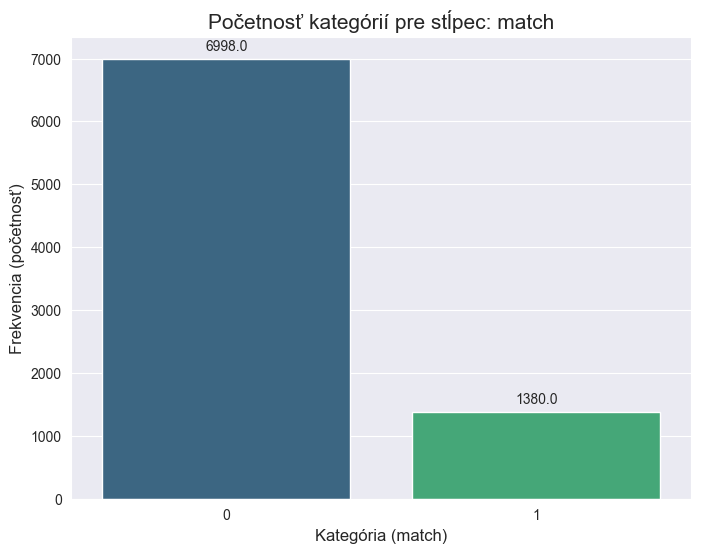

In [65]:
plt.figure(figsize=(8, 6))

# Funkcia sns.countplot automaticky vypočíta počet výskytov každej kategórie
ax = sns.countplot(x="match", data=df, hue="match", legend=False, palette="viridis")

# Nastavenie popiskov a názvu
plt.title(f'Početnosť kategórií pre stĺpec: {"match"}', fontsize=15)
plt.xlabel(f'Kategória ({"match"})', fontsize=12)
plt.ylabel('Frekvencia (početnosť)', fontsize=12)

# Vloženie presných čísel (početnosti) nad každý stĺpec
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.show()


Rozdelíme si dáta na 3 množiny:
- Trénovacia množina (70% dát) - na trénovanie modelu
- Validačná množina (15% dát) - na ladenie hyperparametrov modelu
- Testovacia množina (15% dát) - na finálne otestovanie modelu

Tento pomer môže byť aj iný ale 70/15/15 je bežný štandard.



In [66]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    df_clean.drop(columns=['match']),
    df_clean['match'],
    test_size=0.15,
    random_state=42,
    stratify=df_clean['match']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,  # približne 15% z pôvodných dát
    random_state=42,
    stratify=y_temp
)

print(f"Tréningová množina: {X_train.shape[0]} vzoriek")
print(f"Validačná množina: {X_val.shape[0]} vzoriek")
print(f"Testovacia množina: {X_test.shape[0]} vzoriek")

Tréningová množina: 4815 vzoriek
Validačná množina: 1033 vzoriek
Testovacia množina: 1032 vzoriek


Teraz keď máme dáta rozdelené, začneme s predprocesingom.
Všetky tieto kroky budeme ziskávať z trénovacej množiny a aplikovať ich na validačnú a testovaciu množinu.